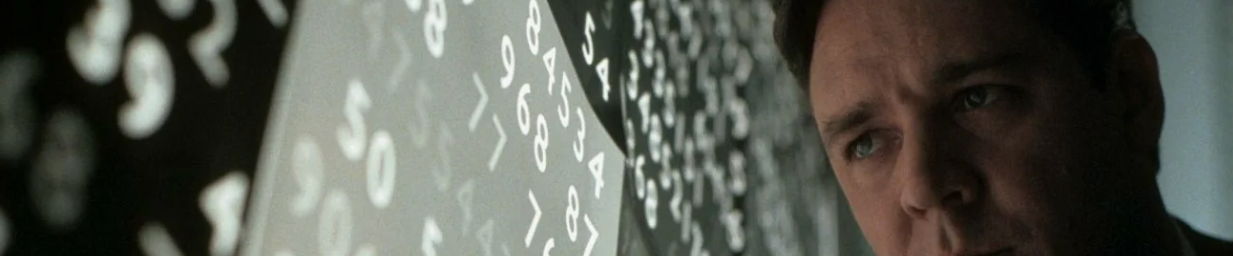

# Защита персональных данных клиентов

**Цель работы**

Защитить данные клиентов страховой компании; разработать такой метод преобразования данных, чтобы по ним было сложно восстановить персональную информацию; после преобразования данных качество модели линейной регрессии не должно ухудшиться.

**Описание данных**

Признаки: пол, возраст и зарплата застрахованного, количество членов его семьи.\
Целевой признак: количество страховых выплат клиенту за последние 5 лет.


**План**

1) загрузка и изучение данных;\
2) разработка алгоритма трансформации данных и осуществление его;\
3) изготовление модели линейной регрессии;\
4) оценка качества работы модели на трансформированных данных с помощью метрики R2.


## Загрузка и анализ данных

In [1]:
import pandas as pd
import numpy as np
from numpy.linalg import inv
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression

In [2]:
try:
    data = pd.read_csv('../../14 линейная алгебра/project/insurance.csv')
except:
    try:
        data = pd.read_csv('/datasets/insurance.csv')
    except:
        data = pd.read_csv('https://code.s3.yandex.net/datasets/insurance.csv')

In [3]:
data.head()

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Пол                5000 non-null   int64  
 1   Возраст            5000 non-null   float64
 2   Зарплата           5000 non-null   float64
 3   Члены семьи        5000 non-null   int64  
 4   Страховые выплаты  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [5]:
data.duplicated().sum()          # кол-во полных дубликатов

153

In [6]:
data[data.duplicated()].head(10) # полные дубликаты (топ 10)

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
281,1,39.0,48100.0,1,0
488,1,24.0,32900.0,1,0
513,0,31.0,37400.0,2,0
718,1,22.0,32600.0,1,0
785,0,20.0,35800.0,0,0
869,1,24.0,33100.0,1,0
887,1,19.0,35500.0,0,0
1004,1,29.0,42400.0,0,0
1089,0,27.0,46800.0,2,0
1091,1,41.0,34000.0,1,0


В данных 153 дубликата (3%). Предсавленная информация не уникальна и вполне может дублироваться. Т.е. в базе нет таких однозначно идентифицирующих признаков, как паспорт или id.
Удалять не будем.

In [7]:
data.describe()

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.360000,1.194200,0.148000
std,0.500049,8.440807,9900.083569,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


Диаграммы распределения признаков:

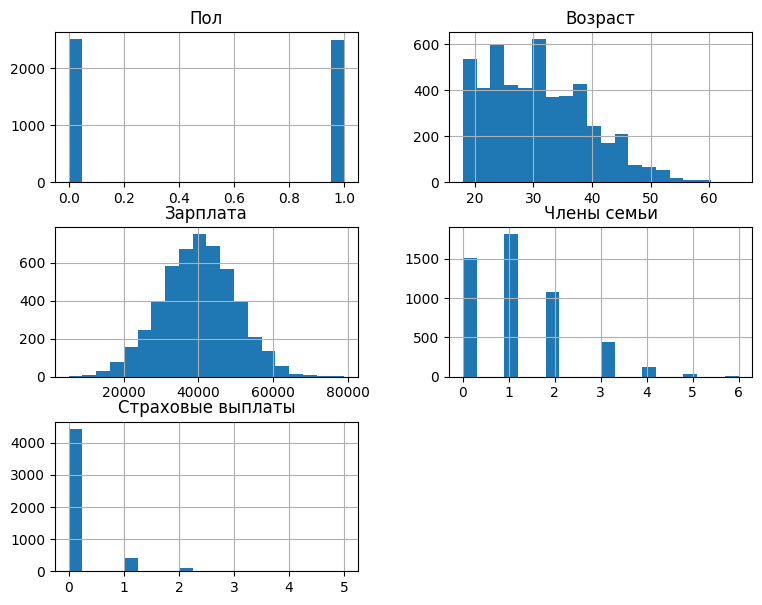

In [8]:
data.hist(figsize=(9,7),bins=20); plt.show()

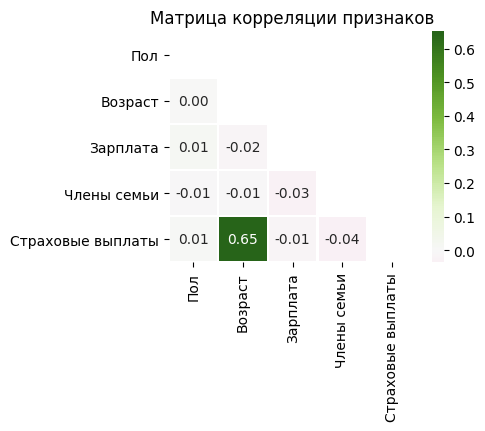

In [9]:
plt.figure(figsize=(4,3))
matrix = np.triu(data.corr())
sns.heatmap(data.corr(),annot=True, cmap='PiYG', linewidth=1, fmt='.2f', center= 0, mask=matrix)
plt.title('Матрица корреляции признаков')
plt.show()

Люди в возрасте чаще обращаются за страховой выплатой.

## Алгоритм преобразования

Для кодирования данных умножим матрицу признаков на произвольную обратимую матрицу.

$ X' = X*P $

Обозначения:

- $X$ — матрица признаков (нулевой столбец состоит из единиц)(размерность m х n)

- $X'$ - новая закодированная матрица

- $y$ — вектор целевого признака

- $P$ — матрица, на которую умножаются признаки (размерность n x n)

- $w$ — вектор весов линейной регрессии (нулевой элемент равен сдвигу)

Предсказания:

$$
a = Xw
$$

Задача обучения:

$$
w = \arg\min_w MSE(Xw, y)
$$

Формула обучения:

$$
w = (X^T X)^{-1} X^T y
$$

**Утверждение**

При умножении признаков на обратимую матрицу качество линейной регрессии не изменится. Модели идентичны.

**Доказательство** 

На основании формулы обучения, и используя свойства матричных операций, определим вектор весов $w'$ в новой трансформированной модели.

<div style="border:solid Chocolate 2px; padding: 5px">

Свойства матричных операций:

$$
(AB)^T=B^T A^T
$$
$$
(AB)^{-1} = B^{-1} A^{-1}
$$
$$
A A^{-1} = A^{-1} A = E
$$
$$
AE = EA = A
$$

$ X' = XP $

$ w' = (X'^TX')^{-1}X'^Ty = ((XP)^T(XP))^{-1}(XP)^Ty = (P^TX^TXP)^{-1}P^TX^Ty = P^{-1}(X^TX)^{-1}P^{T^{-1}}P^TX^Ty  
     = P^{-1}(X^TX)^{-1}E_nX^Ty = P^{-1}(X^TX)^{-1}X^Ty = P^{-1}w $

$ w'= P^{-1}w   $

$ w = Pw'   $



Видим, что векторы весов исходной и трансформированной линейных моделей находятся в зависимости между собой через матричное произведение с участием придуманной обратимой матрицы $P$ (или $P^{-1}$).

$ a(X) = Xw $

$ a'(X') = X'w' = (XP)(P^{-1}w) = XPP^{-1}w = XE_nw = Xw  $

Таким образом:

$ a(X) = a'(X') $

## Проверка алгоритма

### Масштабируем признаки (без целевого)

In [10]:
# отделяем признаки от целевого признака
X = data.drop('Страховые выплаты',axis=1)
y = data['Страховые выплаты']

In [11]:
# разбиваем выборки на обучающую и тестовую (75/25)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12345)

In [12]:
# размеры полученных выборок
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3750, 4)
(1250, 4)
(3750,)
(1250,)


In [13]:
# масштабируем признаки (без целевого)
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled  = scaler.transform(X_test)

### Трансформирование исходных матриц

In [14]:
# создаём обратимую матрицу для трансфорации исходных данных
P = np.array([[ 1, 2, 3, 4],
              [ 5, 6, 7, 8],
              [ 9,10,11,12],
              [13,14,15,16]])

<div style="border:solid Chocolate 2px; padding: 40px">
    
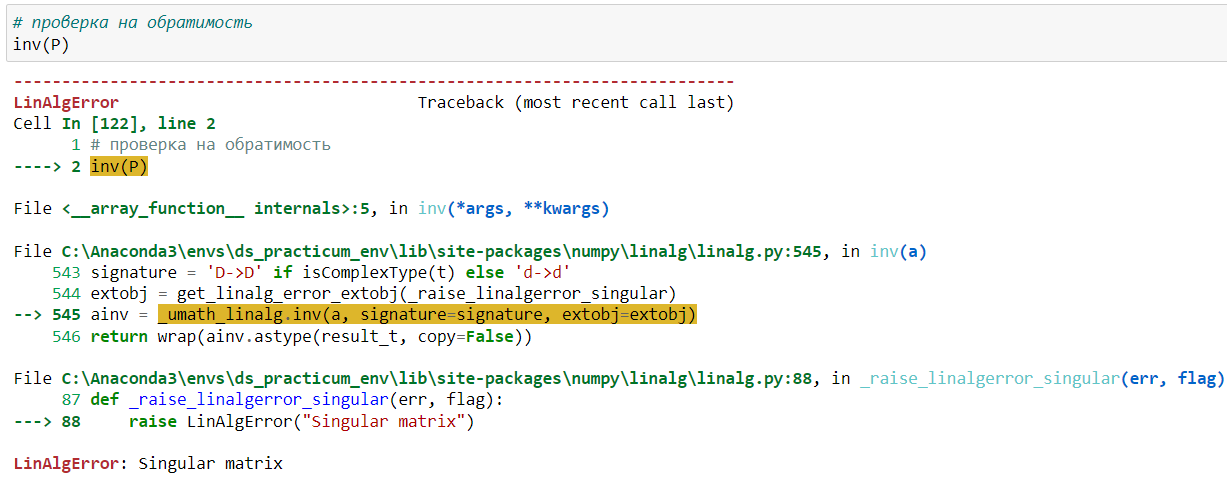

Матрица оказалась необратимой. Пробуем создать другую.

In [15]:
# создаём обратимую матрицу для трансформации исходных данных (попытка 2)
P = np.array([[ 1, 2, 3   ,  4],
              [ 6, 0, 0.25,  9],
              [-1,-3,-5   ,-26],
              [ 2, 4, 7   ,  9]])

In [16]:
inv(P)

array([[ 0.11637487,  0.16065911,  0.07209063, -0.00411946],
       [ 3.45314109, -0.08238929, -0.01132853, -1.48506694],
       [-1.97734295, -0.00411946,  0.04943357,  1.02574665],
       [-0.02265705,  0.00411946, -0.04943357, -0.02574665]])

Подобрана обратимая матрица. Для дальнейших преобразований подходит.

In [17]:
# создаём новые трансформированнные матрицы (признаки)
X_train_new = np.dot(X_train_scaled, P)
X_test_new  = np.dot(X_test_scaled,  P)

In [18]:
X_train_new[0]

array([ 9.51431058,  2.43729685,  4.03453014, 25.00302811])

In [19]:
X_test_new[0]

array([ 5.61871605,  8.55679051, 15.51905418, 23.66639763])

### Модель линейной регрессии

In [20]:
class LinearRegression_handmaid:
    def fit(self, train_features, train_target):
        X = np.concatenate((np.ones((train_features.shape[0], 1)), train_features), axis=1)
        y = train_target
        w = inv(X.T@X)@X.T@y  
        self.w = w[1:]
        self.w0 = w[0]

    def predict(self, test_features):
        return test_features.dot(self.w) + self.w0

In [21]:
# обучение и предсказание по трансформированным данным
model = LinearRegression_handmaid()
model.fit(X_train_new,y_train)
predictions = model.predict(X_test_new)

In [22]:
# метрика качества R2 при обучении на трансформированных данных
r2_score(y_test, predictions)

0.4352275712702671

#### Проверка на исходных данных (без преобразований)

In [23]:
model = LinearRegression_handmaid()
model.fit(X_train_scaled,y_train)
predictions = model.predict(X_test_scaled)

In [24]:
r2_score(y_test, predictions)

0.4352275712702667

#### Проверка на исходных данных (без преобразований) (sklearn) 

In [25]:
model = LinearRegression()
model.fit(X_train_scaled,y_train)
predictions = model.predict(X_test_scaled)

In [26]:
r2_score(y_test, predictions)

0.43522757127026657

## Вывод

1. Исходный датасет размером 5000х5 без пропусков. Идентифицировано 153 дубликата (3%). Так как признаки не уникальны (нет паспортных данных или id) дубликаты возможны; не удалил. Люди в возрасте чаще обращаются за страховой выплатой.
<br><br>
2. В целях защиты данных клиентов разработан следующий метод кодировки:
   Признаки (без целевого) скалярно умножаются на обратимую матрицу.
$$ X' = X*P $$
При необходимости возможно получить исходные данные из закодированных, воспользовавшись обратной матрицей.
<br><br>
3. Написан собственный класс линейной регрессии.\
Метрика качества R2:
- при обучении на трансформированных данных - 0.435;
- на исходных данных (без преобразований) - 0.435;
- на исходных данных (без преобразований) с использованием sklearn- 0.435.
4. Предложенный алгоритм шифрования данных не влияет на результаты работы модели машинного обучения и может быть внедрён в производство.